In [12]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import random
import numpy as np
import torch as T
import scipy.stats as stats
import copy

In [13]:
class RND(nn.Module):
    def __init__(self,in_dim,out_dim):
        super(RND,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.fc1 = nn.Linear(*self.in_dim,64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64,self.out_dim)
        self.relu2 = nn.ReLU()
        
    def forward(self,obs):
        obs = T.FloatTensor(obs)
        state = self.relu1(self.fc1(obs))
        out = self.fc2(state)
        return out

In [14]:
class Qnet(nn.Module):
    def __init__(self,in_dims,n_actions,alpha):
        super(Qnet,self).__init__()
        self.in_dims = in_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.in_dims,256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256,256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256,self.n_actions)
        self.loss = nn.MSELoss() ###
        self.optimizer = optim.RMSprop(params=self.parameters(),lr=alpha)
        
    def forward(self,observation):
        state = T.FloatTensor(observation)
        x = self.relu1(self.fc1(state))
        x = self.relu2(self.fc2(x))
        actions = self.fc3(x)
        return actions

In [15]:
class Agent(object):
    def __init__(self,in_dims,n_actions,alpha,epsilon,gamma,batch_size,reply_mem_size,epsilon_min=0.05,epsilon_decrease=0.996):
        self.in_dims = in_dims
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.batch_size = batch_size
        self.reply_mem_size = reply_mem_size
        self.mem_cntr = 0
        
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decrease = epsilon_decrease
        
        # define memories
        self.state_mem = np.zeros((self.reply_mem_size,*self.in_dims))
        self.action_mem = np.zeros((self.reply_mem_size,self.n_actions))
        self.reward_mem = np.zeros((self.reply_mem_size))
        self.next_state_mem = np.zeros((self.reply_mem_size,*self.in_dims))
        self.is_done_mem = np.zeros((self.reply_mem_size))
        
        # define brain
        self.brain = Qnet(self.in_dims,self.n_actions,self.alpha)
        self.curious = RND(self.in_dims,1)
        
        
    def store_experiance(self,state,action,reward,next_state,is_done,episode_ln = None,pdfs = None):
        index = self.mem_cntr % self.reply_mem_size
        
        self.state_mem[index] = state
        actions = np.zeros(self.n_actions)
        actions[action] = 1.0
        self.action_mem[index] = actions
        self.reward_mem[index] = reward
        self.next_state_mem[index] = next_state
        self.is_done_mem[index] = 1 - is_done
        
        if episode_ln is not None:
            self.reward_mem[index-episode_ln+1 : index+1] = pdfs
        
        
        self.mem_cntr += 1
        
    
    def act(self,observation):
        net_act = self.brain.forward(observation)
        if  np.random.random() > self.epsilon:
            action = T.argmax(net_act).item()
        else:
            action = np.random.choice(self.action_space)
        return action
            
            
    def learn(self):
        if self.mem_cntr > self.batch_size:
            self.brain.optimizer.zero_grad()
            
            max_mem = self.mem_cntr if self.mem_cntr < self.reply_mem_size else self.reply_mem_size
            
            batch = np.random.choice(max_mem,self.batch_size)
            
            state_batch = self.state_mem[batch]
            action_batch = self.action_mem[batch]
            action_values = np.array(self.action_space)
            action_indices = np.dot(action_batch, action_values)
            reward_batch = T.Tensor(self.reward_mem[batch])
            next_state_batch = self.next_state_mem[batch]
            is_done_batch = T.Tensor(self.is_done_mem[batch])
            
            self.q_eval = self.brain.forward(state_batch)
            self.q_target = self.q_eval.clone()
            self.q_next = self.brain.forward(next_state_batch)
            
            batch_index = np.arange(self.batch_size)
            
            self.q_target[batch_index,action_indices] = reward_batch + self.gamma * T.max(self.q_next,dim=1)[0] * is_done_batch
            
#             self.epsilon = self.epsilon * self.epsilon_decrease if self.epsilon > self.epsilon_min else self.epsilon_min
            
            loss = self.brain.loss(self.q_target,self.q_eval)
            loss.backward()
            self.brain.optimizer.step()
            
            

In [16]:
env = gym.make("MountainCar-v0")

state_reset = env.reset()

in_dims = (20*env.observation_space.shape[0],)
n_actions = env.action_space.n
print(in_dims,n_actions)

(40,) 3


In [17]:
alpha = 0.01
epsilon = 0.1
gamma = 0.9
batch_size = 256
reply_mem_size = 10000
driver = Agent(in_dims,n_actions,alpha,epsilon,gamma,batch_size,reply_mem_size)

In [18]:
n_episodes = 5000

In [19]:
# Drastic change in learning after 
# alpha = 0.01
# epsilon = 0.1
# gamma = 0.9
# batch_size = 256
# reply_mem_size = 10000
# and keeping pdfs in range of 0 to 1
# Reached flag within 20 episodes

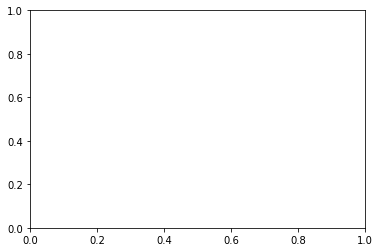

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

In [21]:
scores = []
rew_scores = []
eps_history = []
solved_count = 0
for i in range(n_episodes):
#     print("---------------------------- ","episode",i," --------------------------")
    done = False
    observation = env.reset()
    rewards = 0
    five_states = np.zeros((20,1,2))
    while not done:
        five_states = np.concatenate((five_states[-1].reshape((1,1,2)), five_states[0:-1]))
        five_states[0] = observation.copy()
        action = driver.act(five_states.reshape(40))
        observation_, reward, done, info = env.step(action)
#         env.render()
        rewards += reward
        five_states_next = copy.copy(five_states)
        five_states_next = np.concatenate((five_states_next[-1].reshape((1,1,2)), five_states_next[0:-1]))
        five_states_next[0] = observation_
        driver.store_experiance(five_states.reshape(40), action, reward, five_states_next.reshape(40),done)
        if done:
            states_size = driver.mem_cntr if driver.mem_cntr < driver.reply_mem_size else driver.reply_mem_size
            enc_states = driver.curious.forward(driver.state_mem[:states_size]).detach().numpy().reshape(states_size)
            d = stats.norm(*stats.norm.fit(enc_states))
            pdfs = d.pdf(enc_states)
            pdfs = (pdfs - np.min(pdfs))/(np.max(pdfs) - np.min(pdfs))
#             pdfs = pdfs-np.mean(pdfs)
            pdfs = -1 * pdfs
            
#             pdfs = pdfs -1
            driver.reward_mem[:states_size] = pdfs
        observation = observation_
#     env.close()
    score = pdfs.sum()
    driver.learn()
#     if i % 20 == 0:
#         plt.hist(enc_states)
#         plt.show()
#         fig.clear()
    scores.append(score)
    rew_scores.append(rewards)
    if rewards > -140:
        print("solved")
        solved_count += 1
        if solved_count == 5:
            print("solved breaking")
            break
    else:
        solved_count = 0
    
    eps_history.append(driver.epsilon)
    if i % 100 == 0:
        print("episode :",i,"\n","avg_score :",np.mean(scores[max(0, i-100):(i+1)]),"\n","epsilon :",driver.epsilon)
#         print("episode :",i,"\n","avg_score :",scores[i],"\n","epsilon :",driver.epsilon)

episode : 0 
 avg_score : -137.0251062457795 
 epsilon : 0.1
episode : 100 
 avg_score : -6069.96065806485 
 epsilon : 0.1
episode : 200 
 avg_score : -8093.395530423619 
 epsilon : 0.1
episode : 300 
 avg_score : -7862.782597483515 
 epsilon : 0.1
episode : 400 
 avg_score : -7817.382423338463 
 epsilon : 0.1
episode : 500 
 avg_score : -7727.18164273696 
 epsilon : 0.1
episode : 600 
 avg_score : -7722.795589889723 
 epsilon : 0.1
episode : 700 
 avg_score : -7793.244988989576 
 epsilon : 0.1
episode : 800 
 avg_score : -7997.784519145482 
 epsilon : 0.1
episode : 900 
 avg_score : -7916.26157359258 
 epsilon : 0.1
episode : 1000 
 avg_score : -8024.925992718561 
 epsilon : 0.1
episode : 1100 
 avg_score : -7924.909178487444 
 epsilon : 0.1
episode : 1200 
 avg_score : -7932.631919244568 
 epsilon : 0.1
episode : 1300 
 avg_score : -7957.764764210253 
 epsilon : 0.1
episode : 1400 
 avg_score : -7935.640785733005 
 epsilon : 0.1
episode : 1500 
 avg_score : -7835.791356852246 
 epsil

KeyboardInterrupt: 

In [22]:
import matplotlib.pyplot as plt

(array([  50.,  317.,  239.,  144.,  116.,  115., 2025., 3234., 2085.,
        1675.]),
 array([0.08750637, 0.10219062, 0.11687487, 0.13155912, 0.14624336,
        0.16092762, 0.17561187, 0.19029611, 0.20498036, 0.21966462,
        0.23434886], dtype=float32),
 <a list of 10 Patch objects>)

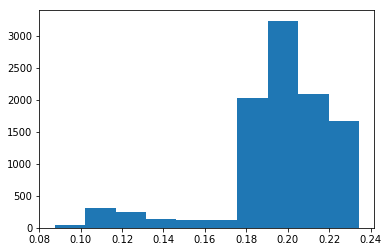

In [23]:
plt.hist(enc_states)

(array([5258., 1035.,  827.,  864.,  725.,  398.,  113.,   30.,   39.,
         711.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0. ]),
 <a list of 10 Patch objects>)

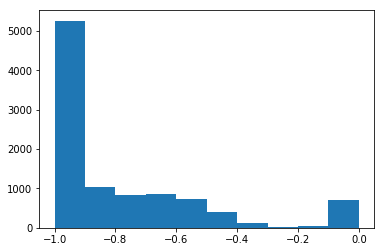

In [24]:
plt.hist(pdfs)

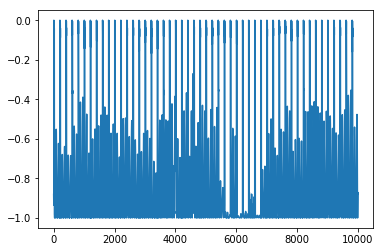

In [25]:
plt.plot(pdfs)

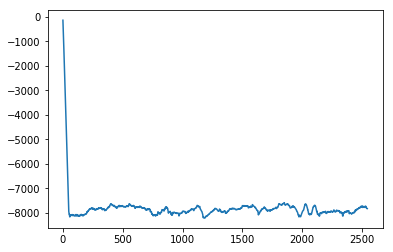

In [26]:
plt.plot(scores)

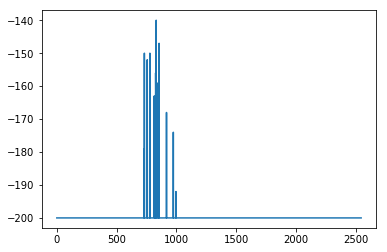

In [27]:
plt.plot(rew_scores)

In [28]:
# driver = torch.load('mountain_car_700ep_eps0.1_lr0.01_rplmem100000_btch256_gamma0.9')

In [29]:
# torch.save(driver,'mountain_car_700ep_eps0.1_lr0.01_rplmem100000_btch256_gamma0.9')

In [30]:
import time

In [31]:
driver.epsilon = 0.0000001
# driver.epsilon = 1.0
rewards_lst = []
for e in range(1):
    done = False
    observation = env.reset()
    rewards = 0
    five_states = np.zeros((20,1,2))
    while not done:
        five_states = np.concatenate((five_states[-1].reshape((1,1,2)), five_states[0:-1]))
        five_states[0] = observation.copy()
        action = driver.act(five_states.reshape(40))
        env.render()
        observation_, reward, done, info = env.step(action)
        rewards += reward
        observation = observation_
    env.close()
    print(rewards)
    rewards_lst.append(rewards)
    time.sleep(4)

-200.0


In [59]:
solved_count

0

In [149]:
np.mean(rewards_lst)

-138.48

In [39]:
env.close()

In [78]:
# torch.save(driver,'lunar_lander_3780ep_0.001_0.1_0.9_1024_100000_shaky_wrkround')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Qnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MSELoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [218]:
driver = torch.load('mountaincar_27520ep_0.001_0.1_0.9_2048_100000')

In [16]:
# torch.save(driver,'mountaincar_27520ep_0.001_0.1_0.9_2048_100000')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Qnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MSELoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
# torch.save(driver,'cartpole_120ep_0.001_1.0_0.9996_everysteplrn_0.9_248_100000')

In [19]:
# torch.save(driver,'Acrobot_600ep_0.001_1.0_0.996_0.9_248_100000')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Qnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MSELoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [96]:
import matplotlib.pyplot as plt

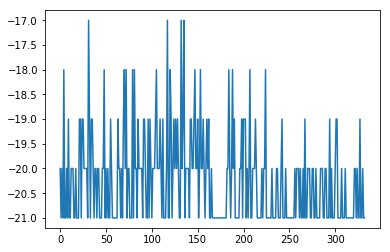

In [184]:
plt.plot(scores)

In [150]:
list(np.array(scores[2500:]) > 190).count(False)

6185

In [27]:
y = []
for i in range(1000):
    y.append(np.random.random() > 0.9)

In [29]:
y.count(False)

888

In [26]:
# loss = -m.log_prob(action) * reward
# loss.backward()

In [17]:
def cumulative_disc_rw(rewards,gamma):
    cumulative_rw = [sum(rewards[i:]) for i in range(len(rewards))]
    return cumulative_rw

In [18]:
data = []
net = Net(in_features,out_features)
n_episodes = 100
batch_size = 512
gamma = 0.9
optimizer = optim.Adam(params=net.parameters(),lr=0.0001)
for e in range(n_episodes):
#     print('-----------',e,'------------','\n','length of data',len(data))
    states = []
    actions = []
    rewards = []
    state = env.reset()
    done = False
    while not done:
        probs = net(torch.FloatTensor(state))
        m = Categorical(probs)
        action = m.sample().item()
#         action = env.action_space.sample()
        state,reward,done,_ = env.step(action)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        if done:
            break
#         env.render()
    env.close()
#     data.extend(list(zip(states,actions,rewards)))
    data.extend(list(zip(states,actions,cumulative_disc_rw(rewards,gamma))))
    
    if (len(data) > 1000) & (e % 3 == 0):
#         print('Training Network')
        
        batch = random.sample(data,k=batch_size)
        states_v = list(zip(*batch))[0]
        acts_v = list(zip(*batch))[1]
        rewards_v = list(zip(*batch))[2]
        rewards_v = np.array(rewards_v)
        rewards_v = rewards_v/(rewards_v.max()-rewards_v.min())
        acts_prob = net(torch.FloatTensor(states_v).view(batch_size,2))
        log_acts_v = torch.log(acts_prob)
        selected_log_prob = torch.FloatTensor(rewards_v) * log_acts_v[np.arange(len(acts_v)),acts_v]
        loss = -selected_log_prob.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if len(data) > 5000:
#         print("setting data to 5000")
        data = data[-5000:]
    if e % 100 == 0:
        print('-------------',e,'----------------')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


------------- 0 ----------------


In [19]:
for e in range(10):
    state = env.reset()
    done = False
    while not done:
        probs = net(torch.FloatTensor(state))
        action = np.argmax(probs.detach().numpy())
#         action = env.action_space.sample()
        state,reward,done,_ = env.step(action)
        if done:
            break
        env.render()
    env.close()

NameError: name 'net' is not defined